# CS5814: Assignment 3

## Problem 2

In problem involves using an autoencoder based filtering technique to recommend movies to users. This is similar to what Netflix uses for its movie recommendations.

The MovieLens 100K dataset is used for this problem.

**Main todo is to determine how to use the training set (split on movies or user?) - currently using user as movies had validation loss way below test for some reason**

## Imports and config

In [28]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import random
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt


In [2]:
# Setting random seeds

RANDOM_SEED = 3819969

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### Configuring Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive/CS5814/HW3/Q2/

/content/drive/MyDrive/CS5814/HW3/Q2


In [5]:
# Checking GPU configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data preprocessing functions

In [6]:
def read_data(file_loc):
    """
    Extacting data from provided CSVs
    """

    # TODO - change name of ratings to all (as it contains all the users)
    
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv('{}/u.user'.format(file_loc), sep="|", names=u_cols, encoding='latin-1')

    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('{}/u.data'.format(file_loc), sep='\t', names=r_cols, encoding='latin-1')

    i_cols = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action',
              'Adventure',
              'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    items = pd.read_csv('{}/u.item'.format(file_loc), sep='|', names=i_cols, encoding='latin-1')

    train = pd.read_csv('{}/u1.base'.format(file_loc), sep='\t', names=r_cols, encoding='latin-1')
    test = pd.read_csv('{}/u1.test'.format(file_loc), sep='\t', names=r_cols, encoding='latin-1')

    return users, ratings, items, train, test

In [8]:
def generate_user_vectors(data, save=True):
    """
    Creates a vector of length # total movies
    elements = 1 if the user has watched or 0 if not
    """

    # TODO - think this needs to be changed based on most recent piazza post!
    # Currently working without a test set

    users, all, items, train, test = data  # Unpacking

    movie_count = items.shape[0]

    user_vectors_train = []
    user_vectors_test = []
    user_vectors_all = []


    for user_id in tqdm(list(users['user_id'])):
        # user_movies = sorted_users.query('user_id=={}'.format(user_id))['movie_id']
        # one_hot_user_movies = [int(i in list(user_movies)) for i in range(1, movie_count + 1)]

        user_movies_train = train.query('user_id=={}'.format(user_id))['movie_id']
        one_hot_user_movies_train = [int(i in list(user_movies_train)) for i in range(1, movie_count + 1)]

        user_movies_test = test.query('user_id=={}'.format(user_id))['movie_id']
        one_hot_user_movies_test = [int(i in list(user_movies_test)) for i in range(1, movie_count + 1)]

        user_movies_all = all.query('user_id=={}'.format(user_id))['movie_id']
        one_hot_user_movies_all = [int(i in list(user_movies_test)) for i in range(1, movie_count + 1)]

        user_vectors_train.append(one_hot_user_movies_train)
        user_vectors_test.append(one_hot_user_movies_test)
        user_vectors_all.append(one_hot_user_movies_all)

    # Convert resultant lists into numpy arrays for saving
    np_user_vectors_train = np.array(user_vectors_train)
    np_user_vectors_test = np.array(user_vectors_test)
    np_user_vectors_all = np.array(user_vectors_all)


    if save:
        np.save('q2_np_user_vectors_train', np_user_vectors_train)
        np.save('q2_np_user_vectors_test', np_user_vectors_test)
        np.save('q2_np_user_vectors_all', np_user_vectors_all)

    return np_user_vectors_train, np_user_vectors_test, np_user_vectors_all

In [9]:
def generate_data_loader(data, batch_size, shuffle):
    """
    Converts a given dataset into a data loader (inputs=outputs)
    """

    # Input and outputs are the same (Auto encoder)
    tensor_x = torch.Tensor(data)  # transform to torch tensor
    tensor_y = torch.Tensor(data)

    dataset = TensorDataset(tensor_x, tensor_y)  # create dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)  # create dataloader

    return dataloader


## AutoEncoder Definition

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, channels):
        super().__init__()

        # Activation functions
        a = nn.LeakyReLU(0.2)
        output_a = nn.Sigmoid()

        # Layer definitions
        l1 = nn.Linear(channels, 512)
        l2 = nn.Linear(512, 256)
        l3 = nn.Linear(256, 32)
        l4 = nn.Linear(32, 256)
        l5 = nn.Linear(256, 512)
        l6 = nn.Linear(512, channels)

        # Collation of network layers into AutoEncoder
        layers = [l1, a, l2, a, l3, a, l4, a, l5, a, l6, output_a]

        self.module_list = nn.ModuleList(layers)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x


## Training loop function

In [52]:
def train(model, num_epochs, train_dl, val_dl):
    """
    Main training loop for auto encoder
    Validating on every epoch due to low training times

    Returns: model, training_loss_array, validation_loss_array
    """


    # Tracking arrays
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    # Configuring model
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    p_list = []
    r_list = []

    for epoch in range(num_epochs):

        # Training
        model.train()
        for i, data in enumerate(train_dl):
            x_batch, y_batch = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            
            # Forward pass
            pred = model.forward(x_batch)
            loss = criterion(pred, y_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Tracking
            loss_hist_train[epoch] += loss.item()

        # Normalizing across training set
        loss_hist_train[epoch] /= (i + 1)

        # Validation
        model.eval()
        for j, data in enumerate(val_dl):
            x_batch, y_batch = data[0].to(device), data[1].to(device)

            pred = model.forward(x_batch)
            loss = criterion(pred, y_batch)
            loss_hist_valid[epoch] += loss.item()

        # Averaging across validation set
        loss_hist_valid[epoch] /= (j + 1)

        # Calulating validation metrics
        p, r = precision_recall(model, val_dl)
        p_list.append(p)
        r_list.append(r)
        # Outputting results
        print("Epoch: {}, Train_Loss: {:.4f}, Val_Loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(epoch,
                                                                                              loss_hist_train[epoch],
                                                                                              loss_hist_valid[epoch],
                                                                                              p, r))

    return model, loss_hist_train, loss_hist_valid, p_list, r_list


## Post processing functions

In [12]:
def recommendations(model, user_data, count=10):
    """
    Determines recomendations based on movies that all users have watched
    Ranks the auto encoders outputs, after subtracting watched movies

    Returns: recomendation_list: 2D list of ordered movie ids for each user
             recomendation_raiting_list: associated autoencoder output for
                                           each movie in recomendation_list

    # TODO - this would be better done with a DataFrame/ziped vs 2 lists
    """


    recomendation_list = []
    recomendation_raiting_list = []

    # Iterating through all users in user data
    for k, data in enumerate(user_data):

        # Getting predictions
        x_batch = data[0].to(device) # this doesnt need to be on GPU
        pred = model.forward(x_batch)

        # Subtracting movies that have been watched
        pred = pred.cpu().detach().numpy() - x_batch.cpu().detach().numpy()
        
        # Sorting before appending movies and probabilties
        movie_recomendations = pred.argsort()[:, -count:][:, ::-1]
        recomendation_list.append(list(movie_recomendations[0]))
        recomendation_raiting_list.append(pred[0][movie_recomendations[0]])

    return recomendation_list, recomendation_raiting_list

In [20]:
def precision_recall(model, user_data):

    recomendation_list = []
    recomendation_raiting_list = []

    precision_list = []
    recall_list = []

    for k, data in enumerate(user_data):
        x_batch = data[0].to(device) # TODO - this doesnt need to be on GPU
        pred = model.forward(x_batch)

        pred = pred.cpu().detach().numpy()
        pred = (pred > 0.5).astype(int)
        target = x_batch.cpu().detach().numpy().astype(int)
        
        matches = pred==target

        precision, recall, f1, _ = precision_recall_fscore_support(target[0], pred[0], average='macro', zero_division=0)
        precision_list.append(precision)
        recall_list.append(recall)
    return(np.average(precision_list), np.average(recall_list))
    #print(pred, target, matches)
    #total_matches = np.sum(matches)
    #print(total_matches)

In [54]:
def plotter(a, b, a_label, b_label, y_label = "Loss"):
  plt.plot(a, label=a_label)
  plt.plot(b, label=b_label)
  plt.xlabel("Epoch")
  plt.ylabel(y_label)
  plt.legend()
  plt.grid()
  plt.show()

# Running model

In [40]:
# Loading data if preprocessed, else generating
load_data = True
target_files = ['q2_np_user_vectors_train.npy',
                'q2_np_user_vectors_test.npy',
                'q2_np_user_vectors_all.npy']

if (Path(target_files[0]).is_file() and Path(target_files[1]).is_file() and Path(target_files[2]).is_file()) and load_data:
    np_train_vectors = np.load("q2_np_user_vectors_train.npy")
    np_test_vectors = np.load("q2_np_user_vectors_test.npy")
    np_all_vectors = np.load("q2_np_user_vectors_all.npy")

else:
    np_train_vectors, np_test_vectors, np_all_vectors = generate_user_vectors(data=read_data(file_loc='datasets/ml-100k'))

# Loading in files of interest
users, ratings, items, train_data, test_data = read_data(file_loc='datasets/ml-100k') 

100%|██████████| 943/943 [00:49<00:00, 18.96it/s]


In [41]:
# Splitting training data into train and val
np.random.shuffle(np_train_vectors)
split_id = int(0.8 * len(np_train_vectors))
train_dataset, val_dataset = np_train_vectors[:split_id], np_train_vectors[split_id:]

# Now using test set as validation

# Generating data loaders
dataloader_train = generate_data_loader(data=train_dataset,
                                        batch_size=32,
                                        shuffle=True)

dataloader_val = generate_data_loader(data=val_dataset,
                                      batch_size=32,
                                      shuffle=True)

# TODO - determine if you can batch these and still track the user ID (?)

dataloader_test = generate_data_loader(data=np_test_vectors,
                                        batch_size=1,
                                        shuffle=False)

dataloader_all = generate_data_loader(data=np_all_vectors,
                                    batch_size=1,
                                    shuffle=False)


In [53]:
# Defining AutoEncoder model
model = AutoEncoder(channels=np_train_vectors.shape[1])

# Training model
model, loss_hist_train, loss_hist_valid, p_list, r_list = train(model=model,
                                                num_epochs=50,
                                                train_dl=dataloader_train,
                                                val_dl=dataloader_val)

Epoch: 0, Train_Loss: 0.4247, Val_Loss: 0.2084, Precision: 0.6830, Recall: 0.5938
Epoch: 1, Train_Loss: 0.1785, Val_Loss: 0.1378, Precision: 0.5082, Recall: 0.5005
Epoch: 2, Train_Loss: 0.1482, Val_Loss: 0.1277, Precision: 0.5488, Recall: 0.5067
Epoch: 3, Train_Loss: 0.1395, Val_Loss: 0.1234, Precision: 0.6589, Recall: 0.5115
Epoch: 4, Train_Loss: 0.1359, Val_Loss: 0.1183, Precision: 0.7576, Recall: 0.5852
Epoch: 5, Train_Loss: 0.1292, Val_Loss: 0.1156, Precision: 0.7078, Recall: 0.5946
Epoch: 6, Train_Loss: 0.1281, Val_Loss: 0.1143, Precision: 0.6913, Recall: 0.6356
Epoch: 7, Train_Loss: 0.1271, Val_Loss: 0.1124, Precision: 0.7392, Recall: 0.5453
Epoch: 8, Train_Loss: 0.1249, Val_Loss: 0.1115, Precision: 0.5661, Recall: 0.5164
Epoch: 9, Train_Loss: 0.1231, Val_Loss: 0.1105, Precision: 0.6195, Recall: 0.5193
Epoch: 10, Train_Loss: 0.1220, Val_Loss: 0.1101, Precision: 0.7161, Recall: 0.5805
Epoch: 11, Train_Loss: 0.1204, Val_Loss: 0.1099, Precision: 0.6905, Recall: 0.5651
Epoch: 12, Tra

### Generating plots

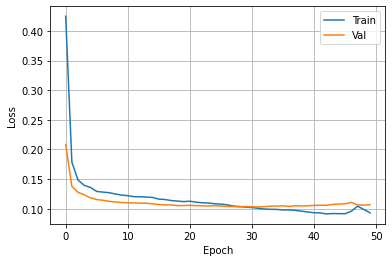

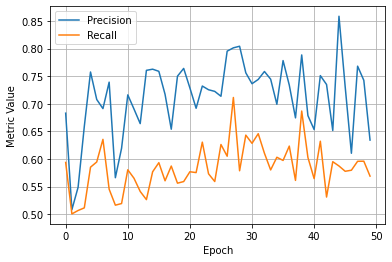

In [55]:
plotter(loss_hist_train, loss_hist_valid, "Train", "Val", y_label = "Loss")
plotter(p_list, r_list, "Precision", "Recall", y_label = "Metric Value")


 Training loss is measured during each epoch while validation loss is measured after each epoch, which can explain the initally lower validation loss.

 Clear that around 30th epoch over fitting is starting.

## Retraining model after epoch count identified

In [60]:
# Defining AutoEncoder model
model = AutoEncoder(channels=np_train_vectors.shape[1])

# Training model
model, loss_hist_train, loss_hist_valid, p_list, r_list = train(model=model,
                                                num_epochs=30,
                                                train_dl=dataloader_train,
                                                val_dl=dataloader_val)

Epoch: 0, Train_Loss: 0.4030, Val_Loss: 0.1996, Precision: 0.5983, Recall: 0.5196
Epoch: 1, Train_Loss: 0.1747, Val_Loss: 0.1380, Precision: 0.6558, Recall: 0.5042
Epoch: 2, Train_Loss: 0.1466, Val_Loss: 0.1278, Precision: 0.7470, Recall: 0.5065
Epoch: 3, Train_Loss: 0.1373, Val_Loss: 0.1191, Precision: 0.6315, Recall: 0.5289
Epoch: 4, Train_Loss: 0.1308, Val_Loss: 0.1156, Precision: 0.8079, Recall: 0.5642
Epoch: 5, Train_Loss: 0.1280, Val_Loss: 0.1142, Precision: 0.6513, Recall: 0.5202
Epoch: 6, Train_Loss: 0.1265, Val_Loss: 0.1119, Precision: 0.6561, Recall: 0.5473
Epoch: 7, Train_Loss: 0.1236, Val_Loss: 0.1116, Precision: 0.7099, Recall: 0.5651
Epoch: 8, Train_Loss: 0.1238, Val_Loss: 0.1109, Precision: 0.7285, Recall: 0.5672
Epoch: 9, Train_Loss: 0.1222, Val_Loss: 0.1107, Precision: 0.7748, Recall: 0.5699
Epoch: 10, Train_Loss: 0.1206, Val_Loss: 0.1099, Precision: 0.7781, Recall: 0.5687
Epoch: 11, Train_Loss: 0.1207, Val_Loss: 0.1093, Precision: 0.6914, Recall: 0.6261
Epoch: 12, Tra

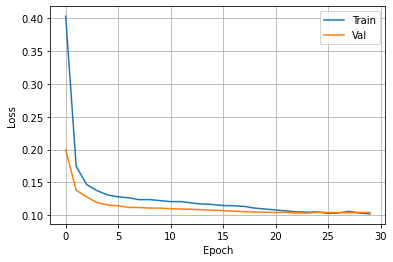

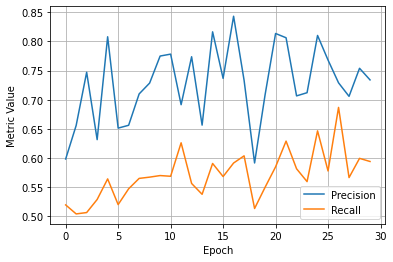

In [62]:
plotter(loss_hist_train, loss_hist_valid, "Train", "Val", y_label = "Loss")
plotter(p_list, r_list, "Precision", "Recall", y_label = "Metric Value")

### Generating recomendations

In [63]:
movie_recomendations, movie_raitings = recommendations(model,
                                        dataloader_all,
                                        count=10)

In [70]:
users_to_print = [25, 255]
movie_names = []
for user_movie_recomendations in movie_recomendations:
    movie_names.append(list(items[(items['movie id']-1).isin(user_movie_recomendations)]['movie title']))


with open("pred_autoencoder.txt", "w") as file:
  for i, user_id in enumerate(range(users.shape[0])):

    output = '\nUser {} top {} recomendations:\n'.format(user_id+1, 10)
    file.write(output)

    if (i+1) in users_to_print:
      print(output)

    for movie_index, movie in enumerate(movie_names[user_id]):
      output = "Raiting: {1:.4f}   Title: {0}\n".format(movie, movie_raitings[user_id][movie_index])
      file.write(output)
      if (i+1) in users_to_print:
          print(output)


User 25 top 10 recomendations:

Raiting: 0.6350   Title: Toy Story (1995)

Raiting: 0.4881   Title: Apollo 13 (1995)

Raiting: 0.4763   Title: Silence of the Lambs, The (1991)

Raiting: 0.4595   Title: Fargo (1996)

Raiting: 0.4526   Title: Amadeus (1984)

Raiting: 0.4437   Title: Back to the Future (1985)

Raiting: 0.4279   Title: When Harry Met Sally... (1989)

Raiting: 0.3984   Title: Schindler's List (1993)

Raiting: 0.3909   Title: Casablanca (1942)

Raiting: 0.3695   Title: It's a Wonderful Life (1946)


User 255 top 10 recomendations:

Raiting: 0.4979   Title: Copycat (1995)

Raiting: 0.4479   Title: Twelve Monkeys (1995)

Raiting: 0.4440   Title: Star Wars (1977)

Raiting: 0.4267   Title: Pulp Fiction (1994)

Raiting: 0.3930   Title: Liar Liar (1997)

Raiting: 0.3859   Title: Titanic (1997)

Raiting: 0.3621   Title: Carrie (1976)

Raiting: 0.3156   Title: Interview with the Vampire (1994)

Raiting: 0.3143   Title: Candyman (1992)

Raiting: 0.3082   Title: I Know What You Did L

### Calculating precision and recall

In [71]:
precision_avg, recall_avg = precision_recall(model, dataloader_all)

print("Using all data")
print("Precision avg: {:.4f}, Recall avg: {:.4f}".format(precision_avg, recall_avg))

Using all data
Precision avg: 0.8004, Recall avg: 0.7642
